# Investigating code posterior effect 

It's [stated](https://arxiv.org/abs/2002.02405) that we should use temperized posterior $p(\theta | D)^{1/T}$ with $T < 1$ to get better performance on test data. We investigate this idea using `hebo.models.nn.sgld.pSGLDEnsemble` and the boston housing dataset.

Actually, in a practical BNN implemntation, instead of directly calculating log posterior, we usually use MSE loss with L1/L2 weight decay, which is already a cold temperized posterior. 

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.distributions import Normal
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from tqdm import trange, tqdm
from hebo.models.model_factory import get_model
import ray

In [35]:
X, y = load_boston(return_X_y = True)
y    = y.reshape(-1,1)
x_tr, x_tst, y_tr, y_tst = train_test_split(X, y, test_size = 0.3, shuffle = True)
x_tr = torch.from_numpy(x_tr).float()
y_tr = torch.from_numpy(y_tr).float()
x_tst = torch.from_numpy(x_tst).float()
y_tst = torch.from_numpy(y_tst).float()

In [45]:
@ray.remote
def fitting(temp):
    model = get_model('psgld', x_tr.shape[1], 0, y_tr.shape[1], 
                      output_noise = False, act = torch.nn.Mish(),
                      num_epochs   = 100,
                      num_layers   = 2,
                      num_hiddens  = 64,
                      temperature  = temp
                     )
    model.fit(x_tr, None, y_tr)
    with torch.no_grad():
        py, ps2 = model.predict(x_tst, None)
        rmse    = mean_squared_error(y_tst.numpy(), py.numpy(), squared = False)
        nll     = -1 * Normal(py, ps2.sqrt()).log_prob(y_tst).mean().item()
        return [temp, rmse, nll]

In [46]:
ray.init(num_cpus = 5, ignore_reinit_error=True)
result = np.array(ray.get([fitting.remote(temp) for temp in np.logspace(-2,2,50)]))

Text(0, 0.5, 'rmse')

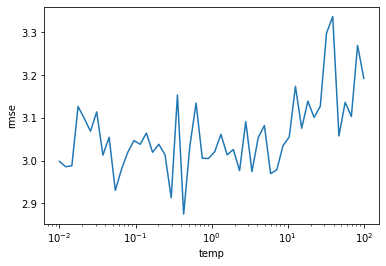

(pid=None) [2022-01-10 11:20:11,566 C 12420 13048] redis_client.cc:87:  Check failed: under_retry_limit Expected 1 Redis shard addresses, found 8247328359524230500
(pid=None) *** StackTrace Information ***
(pid=None)     configthreadlocale
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 


 pid=36388) temp = 0.001, rmse = 4.57, nll = 8.25
 pid=33264) temp = 0.001, rmse = 4.47, nll = 20.50
 pid=24512) temp = 0.001, rmse = 4.38, nll = 4.22
 pid=18436) temp = 0.001, rmse = 4.71, nll = 9.04
 pid=9844) temp = 0.001, rmse = 4.54, nll = 30.54
 pid=36388) temp = 0.002, rmse = 4.63, nll = 6.43
 pid=18436) temp = 0.002, rmse = 4.49, nll = 4.53
 pid=9844) temp = 0.002, rmse = 4.49, nll = 5.25
 pid=33264) temp = 0.001, rmse = 4.69, nll = 4.24
 pid=24512) temp = 0.002, rmse = 4.42, nll = 7.57
 pid=36388) temp = 0.002, rmse = 4.77, nll = 4.21
 pid=18436) temp = 0.002, rmse = 4.54, nll = 4.59
 pid=33264) temp = 0.002, rmse = 4.57, nll = 29.34
 pid=24512) temp = 0.002, rmse = 4.82, nll = 14.60
 pid=9844) temp = 0.003, rmse = 4.66, nll = 3.55
 pid=18436) temp = 0.003, rmse = 4.57, nll = 4.65
 pid=9844) temp = 0.004, rmse = 4.44, nll = 7.57
 pid=33264) temp = 0.003, rmse = 4.60, nll = 9.72
 pid=24512) temp = 0.003, rmse = 5.06, nll = 8.64
 pid=36388) temp = 0.003, rmse = 4.48, nll = 7.99


 pid=36388) temp = 41.027, rmse = 4.32, nll = 5.06
 pid=24512) temp = 43.976, rmse = 4.53, nll = 5.71
 pid=9844) temp = 54.159, rmse = 4.67, nll = 4.63
 pid=33264) temp = 47.138, rmse = 4.61, nll = 4.79
 pid=18436) temp = 50.526, rmse = 4.54, nll = 5.51
 pid=36388) temp = 58.052, rmse = 4.60, nll = 4.94
 pid=24512) temp = 62.226, rmse = 4.63, nll = 8.44
 pid=9844) temp = 71.494, rmse = 4.40, nll = 4.34
 pid=33264) temp = 66.699, rmse = 4.45, nll = 13.36
 pid=18436) temp = 76.634, rmse = 4.80, nll = 3.91
 pid=36388) temp = 82.143, rmse = 4.61, nll = 7.11
 pid=24512) temp = 88.049, rmse = 4.55, nll = 7.31
 pid=18436) temp = 108.437, rmse = 4.75, nll = 13.91
 pid=9844) temp = 94.379, rmse = 4.46, nll = 11.28
 pid=33264) temp = 101.164, rmse = 4.77, nll = 11.48
 pid=36388) temp = 116.232, rmse = 4.79, nll = 5.59
 pid=24512) temp = 124.588, rmse = 4.72, nll = 6.35
 pid=9844) temp = 143.146, rmse = 4.92, nll = 4.35
 pid=33264) temp = 133.545, rmse = 4.67, nll = 6.40
 pid=18436) temp = 153.43

(pid=14268) forrtl: error (200): program aborting due to control-BREAK event
(pid=14268) 
(pid=14268) Stack trace terminated abnormally.
(pid=33796) forrtl: error (200): program aborting due to control-BREAK event
(pid=33796) 
(pid=33796) Stack trace terminated abnormally.
(pid=936) forrtl: error (200): program aborting due to control-BREAK event
(pid=936) 
(pid=936) Stack trace terminated abnormally.
(pid=35148) forrtl: error (200): program aborting due to control-BREAK event
(pid=35148) 
(pid=35148) Stack trace terminated abnormally.
(pid=35928) forrtl: error (200): program aborting due to control-BREAK event
(pid=35928) 
(pid=35928) Stack trace terminated abnormally.
(pid=None) [2022-01-10 11:21:41,170 C 32608 25336] redis_client.cc:87:  Check failed: under_retry_limit Expected 1 Redis shard addresses, found 3
(pid=None) *** StackTrace Information ***
(pid=None)     configthreadlocale
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 


In [47]:
plt.semilogx(result[:,0], result[:,1])
plt.xlabel('temp')
plt.ylabel('rmse')